In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
import advertools as adv
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import ComplementNB
import seaborn as sns

In [2]:
langs = ["nl", "da", "de", "it", "es", ]

model = ComplementNB()

stop_words = []
for key in ["danish", "german", "dutch", "italian", "spanish"]:
    stop_words += list(adv.stopwords[key])

cvc = CountVectorizer(stop_words=stop_words)

ans = pd.DataFrame()


def simpleModel(X_train, y_train, X_test):
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    X = cvc.fit_transform(list(X_train) + list(X_test))
    model.fit(X[:len(X_train)], y_train)
    res = model.predict(X[len(X_train):])
    return res


In [3]:
for language in langs:
    print("working on:", language)
    train_data = pd.read_csv(f"../corpus/train/{language}/{language}_plain.csv")
    test_data = pd.read_csv(f"../corpus/test/{language}/{language}_plain.csv")

    res = simpleModel(train_data.text, train_data.label, test_data.text)

    test_data["label"] = res
    test_data = test_data.drop("text", axis=1)
    ans = pd.concat([ans, test_data])
    
results = ans.copy()


working on: nl
Train size: 8313, Test size: 2772
working on: da
Train size: 8314, Test size: 2772
working on: de
Train size: 8313, Test size: 2772
working on: it
Train size: 8314, Test size: 2772
working on: es
Train size: 8314, Test size: 2772


In [4]:
ans["index"] += 1
ans = ans.sort_values(by=["index"])
ans = ans.rename(columns={"index": "id"})
print(ans.head())
ans.to_csv("../submissions/nolang_NB",index=False)

   id     label
0   1   England
0   2   Ireland
1   3   Ireland
0   4   England
1   5  Scotland


In [5]:
kfold = KFold(n_splits=5, shuffle=True, random_state=21)

results = []
actual = []
overall_acc = []
overall_f1 = []
for language in langs:
    print("working on:", language)
    train = pd.read_csv(f"../corpus/train/{language}/{language}_plain.csv")
    acc = []
    f1 = []
    for train_index, test_index in kfold.split(train):
        X_train, X_test = train.text[train_index], train.text[test_index]
        y_train, y_test = list(train.label[train_index]), list(train.label[test_index])

        res = simpleModel(X_train, y_train, X_test)

        acc.append(accuracy_score(res, y_test))
        f1.append(f1_score(res, y_test, average="weighted"))
        results.extend(res)
        actual.extend(y_test)

    overall_acc.extend(acc)
    overall_f1.extend(f1)

    print(acc)
    print("Acc:", np.array(acc).mean())
    print(f1)
    print("F1:", np.array(f1).mean())

print("\nOverall Acc:", np.array(overall_acc).mean())
print("Overall F1:", np.array(overall_f1).mean())


working on: nl
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6651, Test size: 1662
Train size: 6651, Test size: 1662
[0.6464221286831028, 0.6644618159951894, 0.6434155141310884, 0.6425992779783394, 0.644404332129964]
Acc: 0.6482606137835368
[0.6595416924807818, 0.6774207745534138, 0.6624084078424848, 0.6583670830351682, 0.6638163537938165]
F1: 0.664310862341133
working on: da
Train size: 6651, Test size: 1663
Train size: 6651, Test size: 1663
Train size: 6651, Test size: 1663
Train size: 6651, Test size: 1663
Train size: 6652, Test size: 1662
[0.656043295249549, 0.6578472639807577, 0.6470234515935057, 0.6428141912206855, 0.6624548736462094]
Acc: 0.6532366151381415
[0.6737231622772527, 0.6739809981932544, 0.6653848766385819, 0.659170437061748, 0.6794785552906211]
F1: 0.6703476058922917
working on: de
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6651, T

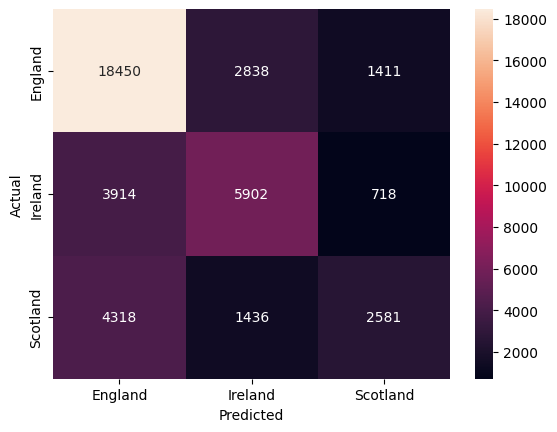

In [9]:
label_vals = ["England", "Ireland", "Scotland"]
conf_mat = confusion_matrix(actual, results)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_vals, yticklabels=label_vals)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
